<IPython.core.display.Javascript object>


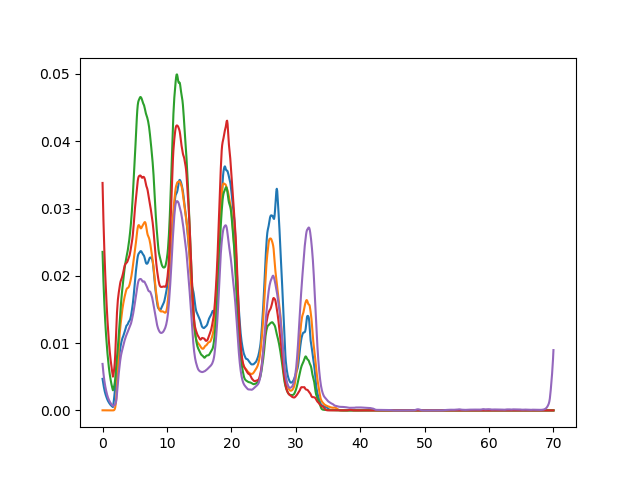

[6.866866866866867, 15.695695695695697, 23.193193193193196, 26.626626626626628, 35.45545545545546, 45.12512512512513, 68.38838838838839]
i is 0
[5.9559559559559565, 9.10910910910911, 15.555555555555555, 23.123123123123126, 29.21921921921922, 35.73573573573574, 68.38838838838839]
i is 16
[9.52952952952953, 15.835835835835837, 23.473473473473476, 29.35935935935936, 35.38538538538538, 68.38838838838839]
i is 32
[6.166166166166167, 15.205205205205205, 23.613613613613616, 29.70970970970971, 68.38838838838839]
i is 48
[6.306306306306307, 15.485485485485485, 22.772772772772775, 29.07907907907908, 36.996996996997]
i is 64


In [4]:
import pickle
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

df = pd.read_csv("1.csv", index_col=0)

%matplotlib notebook
window_len = 16

for i in range(0, 80, window_len):
    obddata = df[df["tripID"].isin(list(range(i, i+window_len)))]
    
    df_ratio = obddata['speed'] / obddata['rpm']
    df_ratio = df_ratio.fillna(0)
    df_ratio = df_ratio[df_ratio != 0]
    df_ratio = df_ratio*1000
    df_ratio.replace(np.inf, np.nan).fillna(0)
    df_ratio[df_ratio > 80] = 0

    sorted_data = df_ratio.sort_values().reset_index(drop=True)
    
    #Smoothening using the convolution method
    """
    Smoothening Function which uses convolution with the window size equal to 
    the box_points i.e. the square matrix has box_points number of columns and rows
    Increasing the number of box_pts allows for a greater smoothening i.e. more of blurring
    """

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth

    """
    X_plot has the X values that are needed to be plot on the histogram or kernel estimation curve, taken as
    1000 points between 0 and 50 since 
    """

    """
    Add another dimension to the arrays since kde requires an axis
    The values in the linespace are chosen so that all the ratio values for the gears have enough points involved
    Also the number of points can be increased to give a more sharp and precise graph
    The Value for the second boundary set according to the car 50 for Jazz, 70 for i20
    """
    X_plot = np.linspace(0, 70, 1000)[:, np.newaxis]
    sorted_data_kernel_fitted = sorted_data[:, np.newaxis]

    """
    Apply kde using the Gaussian kernel and with a bandwith of 0.1. The bandwith is a tuning parameter which determines 
    the standard deviation of the kernels that are being placed in place of each point. Smaller the value more the 
    sharpness in the curves. Kernel could use the tophat kernel but didnt see much of a difference
    """
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian').fit(sorted_data_kernel_fitted)
    """
    Get the logarithmic scores for the points corresponding to the X_plot this is in the log_dens list
    """
    log_dens = kde.score_samples(X_plot)

    # Choose which smoothening method to use
    # Uncomment below line for unsmoothened data
    # smooth_log_dens = log_dens

    # Uncomment below line to use the smooth function defined above which uses the convolution method
    smooth_log_dens = smooth(log_dens, 47)

    # Uncomment below line to use the savitzky_golay function
    # smooth_log_dens = savgol_filter(log_dens, 19, 4)

    # Plot the actual kernel density estimate graph after it has been smoothened
    plt.plot(X_plot[:, 0], np.exp(smooth_log_dens))
    
    #Finding the local minima in density

    """
    Get the local minimas index from the smooth_log_dens values and store it in local_min_ind
    and the actual minima points in the local_min list
    """
    local_min_ind = argrelextrema(smooth_log_dens, np.less)[0]
    local_min = X_plot[local_min_ind]

    """
    Filter the values with absolute probability less than 0.001 : this parameter can be updated to 
    remove as many unneccessary points
    """
    local_min_ind_filtered = list(filter(lambda x : np.exp(smooth_log_dens[x]) >= 0.001, local_min_ind))
    local_min_filtered = local_min
    # Comment the next line for unfiltered data
#     local_min_filtered = X_plot[local_min_ind_filtered]

    """
    Flatten the list to get values in a single list
    """
    local_min_filtered = [x[0] for x in local_min_filtered]
    
    """
    Convert the above list to a series so that we could filter based on the difference too
    """
    local_min_filtered_series = pd.Series(local_min_filtered)
    """
    Add a dummy 0 at the start to account for the first point 
    """
    local_min_filtered_series = pd.Series([0]).append(local_min_filtered_series, ignore_index = True)
    local_min_filtered_series = local_min_filtered_series[local_min_filtered_series.diff() > 3].reset_index(drop=True)

    """
    Convert it back to a list
    """
    local_min_filtered = pd.Series.tolist(local_min_filtered_series)
    
    print(local_min_filtered)
    print("i is " +  str(i))